In [92]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mplhep as hep 
import uproot
from scipy.stats import bootstrap
import re
import sys
plt.style.use(hep.style.CMS)

In [ ]:
# Open the ROOT file and extract the tree
file = uproot.open("output_0.root")
tree = file["EdepCounter"]  # Adjust if the tree name differs

# Convert to pandas DataFrame
df = tree.arrays(library="pd")

# Group by EventID and compute sum of Edep_MeV
sum_edep = df.groupby('EventID')['Edep_MeV'].sum()

# Filter events where sum > 1 MeV
filtered_events = sum_edep[sum_edep > 1].index

# Get the filtered DataFrame (all rows for those EventIDs)
filtered_df = df[df['EventID'].isin(filtered_events)]

# Save to CSV
filtered_df.to_csv('filtered_events.csv', index=False)

/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: Dep

In [225]:
data=pd.read_csv('filtered_events.csv')
index=data.groupby('EventID')['Edep_MeV'].count()<=4
filtered_data=data[data['EventID'].isin(index[index].index)]
index=filtered_data.groupby('EventID')['Edep_MeV'].count()>=3
filtered_data=filtered_data[filtered_data['EventID'].isin(index[index].index)]

In [239]:
def plot_crystals_vectors(crystal_names, crystal_edeps, crystal_times):
    """
    Function to plot multiple crystal centers with vectors to each selected crystal in one plot.
    Vectors colored differently if edep > 0.6 MeV (green) else red.
    Input: 
    - crystal_names (list of str): e.g., ['001', '002'], or full names like ['UntitledPrism12.2mmcalor_unit_001']
    - crystal_edeps (list of float): Corresponding Edep_MeV values for each crystal_name
    - crystal_times (list of float): Corresponding FirstTime_ns values for each crystal_name
    Extracts unit numbers and plots accordingly.
    """
    if len(crystal_names) != len(crystal_edeps) or len(crystal_names) != len(crystal_times):
        raise ValueError("crystal_names, crystal_edeps, and crystal_times must have the same length.")
    
    selected_units = []
    unit_edeps = {}
    unit_times = {}
    for i, name in enumerate(crystal_names):
        # Extract the number part (e.g., '001' or '72' from input)
        match = re.search(r'(\d+)$', name)  # Look for any digits at the end
        if match:
            num_str = match.group(1)
            unit_num = num_str.zfill(3)  # Pad to 3 digits, e.g., '72' -> '072'
            unit_key = f"calor_unit_{unit_num}"
            selected_units.append(unit_key)
            unit_edeps[unit_key] = crystal_edeps[i]
            unit_times[unit_key] = crystal_times[i]
        else:
            raise ValueError(f"Could not extract unit number (e.g., '001' or '72') from {name}.")
    
    # Generate centers
    prism_half_length = 6.1  # mm, based on 12.2 mm naming
    a1_x = 2 * prism_half_length * np.cos(np.deg2rad(30))
    a1_y = 2 * prism_half_length * np.sin(np.deg2rad(30))
    a2_x = 0.0
    a2_y = 2 * prism_half_length
    min_n = 13
    max_n = 15
    count = 0
    centers = {}
    for n1 in range(-max_n, max_n + 1):
        for n2 in range(max(-max_n, -n1 - max_n), min(max_n, -n1 + max_n) + 1):
            ring = max(abs(n1), abs(n2), abs(n1 + n2))
            if min_n <= ring <= max_n:
                x = n1 * a1_x + n2 * a2_x
                y = n1 * a1_y + n2 * a2_y
                z = 0.0
                unit_name = f"calor_unit_{count:03d}"  # Format as calor_unit_000, etc.
                centers[unit_name] = (x, y, z)
                count += 1
    
    # Plot
    fig, ax = plt.subplots()
    for unit, (x, y, z) in centers.items():
        ax.plot(x, y, 'bo', markersize=5)  # All centers in blue
        # Add small detector id label on top of each crystal
        detector_id = unit.split('_')[-1]  # e.g., '000'
        ax.text(x, y + 1, detector_id, fontsize=6, ha='center', va='bottom')  # Small text above point
    
    # Draw positronium source cross-section at center (top view, circles)
    disk_radius = 9.53 / 2  # mm
    ring_radius = 19.1 / 2  # mm
    # Bare source (inner circle, yellow for NaCl)
    bare_circle = plt.Circle((0, 0), disk_radius, color='yellow', fill=True, alpha=0.5, label='Bare Source (NaCl)')
    ax.add_patch(bare_circle)
    # Disk (Ti, thin, but same radius, overlay gray)
    disk_circle = plt.Circle((0, 0), disk_radius, color='gray', fill=False, linewidth=2, label='Ti Disk')
    ax.add_patch(disk_circle)
    # Ring (Ti, outer)
    ring_circle = plt.Circle((0, 0), ring_radius, color='gray', fill=True, alpha=0.3, label='Ti Ring')
    ax.add_patch(ring_circle)
    ring_inner = plt.Circle((0, 0), disk_radius, color='white', fill=True)  # Cut out inner for ring
    ax.add_patch(ring_inner)
    
    # Draw container (cylinder cross-section: outer Acrylic, inner Liquid/Water)
    container_radius = 20.0  # mm (2 cm)
    container_thickness = 1.0  # mm
    liquid_radius = container_radius - container_thickness  # 19 mm
    # Outer container (Acrylic, blue outline)
    container_outer = plt.Circle((0, 0), container_radius, color='blue', fill=False, linewidth=2, label='Container (Acrylic)')
    ax.add_patch(container_outer)
    # Inner liquid (Water, light blue fill)
    liquid_circle = plt.Circle((0, 0), liquid_radius, color='lightblue', fill=True, alpha=0.5, label='Liquid (Water)')
    ax.add_patch(liquid_circle)
    
    missing = []
    for sel_unit in selected_units:
        if sel_unit in centers:
            sx, sy, sz = centers[sel_unit]
            edep = unit_edeps[sel_unit]
            time = unit_times[sel_unit]
            color = 'g' if edep > 0.6 else 'r'  # Green if >0.6 MeV, else red
            # Draw vector (arrow) from center (0,0) to selected crystal
            ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
            ax.plot(sx, sy, f'{color}*', markersize=10)  # Selected star in same color
            print(f"Center position for {sel_unit} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
        else:
            missing.append(sel_unit)
    
    if missing:
        print(f"Detector units not found: {', '.join(missing)}")
    
    ax.set_aspect('equal')  # Equal axis scaling
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('Crystal Center Positions (Vectors: Green if Edep>0.6 MeV, Red otherwise)')
    plt.legend(loc='upper right',fontsize=10)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Center position for calor_unit_102 (Edep=0.25 MeV, Time=8.00 ns): (x=-42.26 mm, y=134.20 mm, z=0.00 mm)
Center position for calor_unit_173 (Edep=0.50 MeV, Time=8.00 ns): (x=84.52 mm, y=-109.80 mm, z=0.00 mm)
Center position for calor_unit_244 (Edep=1.27 MeV, Time=0.00 ns): (x=158.48 mm, y=6.10 mm, z=0.00 mm)
Center position for calor_unit_066 (Edep=0.26 MeV, Time=8.00 ns): (x=-105.66 mm, y=97.60 mm, z=0.00 mm)


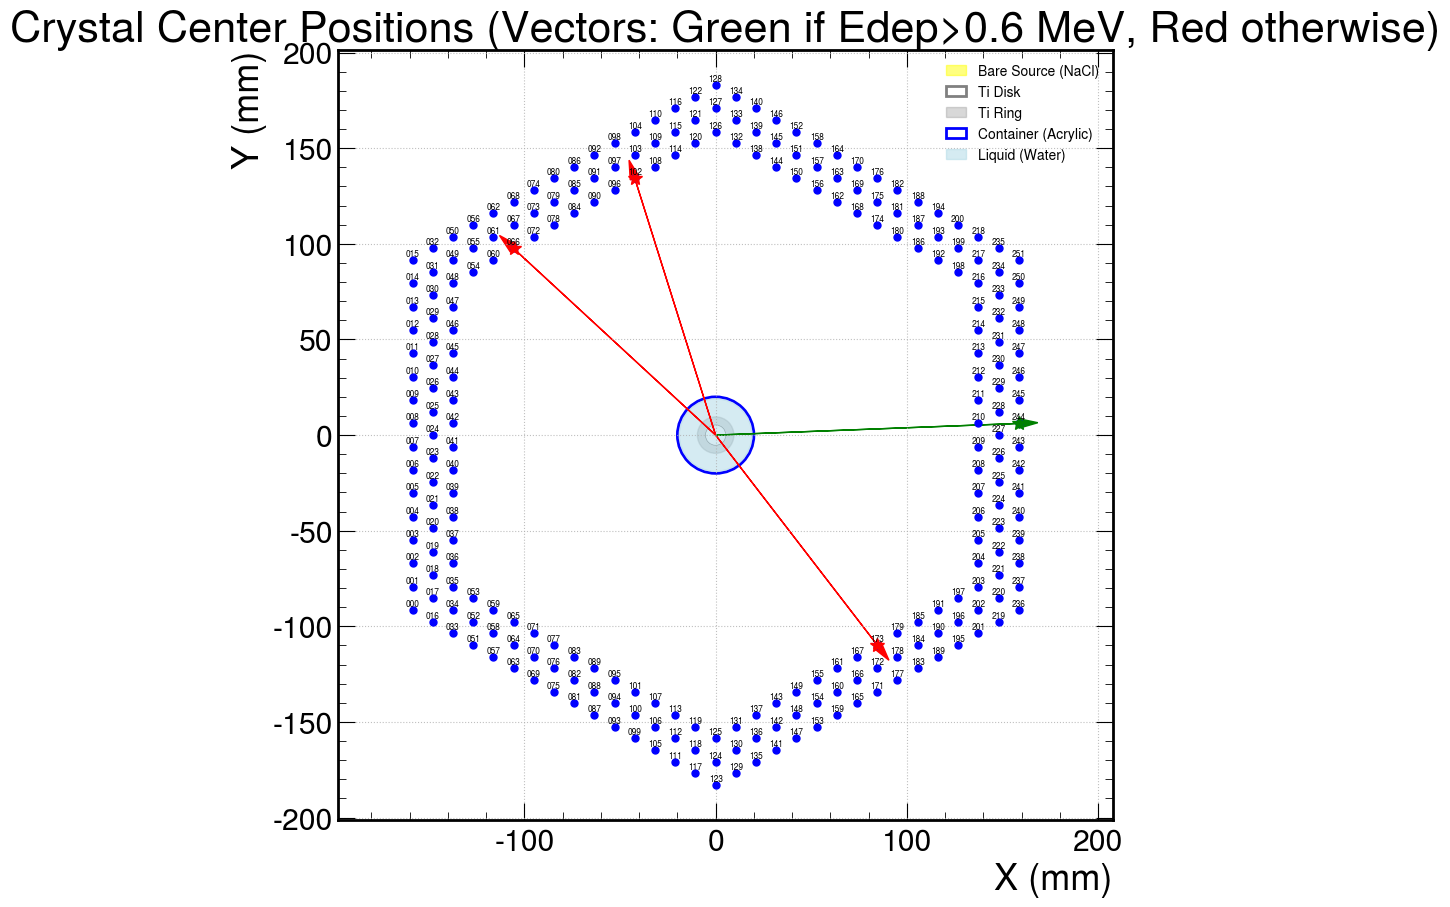

In [243]:
# Mimicked usage snippet (assuming 'filtered_data' and 'data' are your DataFrames)
eid = filtered_data["EventID"].unique()[2]
event_data = data[data["EventID"] == eid]
all_crystal = event_data["DetectorName"].values.tolist()
crystal_edeps = event_data["Edep_MeV"].values.tolist()  # Extract corresponding Edep_MeV
crystal_times = event_data["FirstTime_ns"].values.tolist()  # Extract corresponding FirstTime_ns
crystal_name = []
for crystal in all_crystal:
    current_name = crystal.split("UntitledPrism12.2mmcalor_")[-1].split("_")[-1]
    crystal_name.append(current_name)
plot_crystals_vectors(crystal_name, crystal_edeps, crystal_times)

In [ ]:
crystal_name

['unit_102', 'unit_173', 'unit_244', 'unit_66']